<a href="https://colab.research.google.com/github/tomvmeer/DC3/blob/main/Data_Challenge_1_Template_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction:
In this template, methods are provided to get you started on the task at hand (please see project description). Please implement your solution in the code cells marked with **TODO**. Most of the other code cells are hidden, feel free to explore and change these. These cells implement a basic pipeline for training your model but you may want to explore more complex procedures. **Make sure you run all cells before trying to implement your own solution!**

#Imports and definitions:

In [139]:
import numpy as np
from pathlib import Path
import requests
import io
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import rotate
%matplotlib inline
from torch.utils.data import Dataset
import random
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
from dc1.image_dataset import ImageDataset
from typing import Generator, Tuple, Union
import argparse

In [141]:
# Function with Data Augmentation

class BatchSampler():
    """
    An iterable that produces batches from a given torch dataset.
    In balanced mode, each class is rebalanced to have a fixed target number of samples,
    computed as (largest class original count) * largest_aug_factor.
    For classes with fewer samples, extra samples are generated on the fly via augmentation.
    """
    def __init__(self, batch_size: int, dataset: ImageDataset, balanced: bool = True, largest_aug_factor: int = 1) -> None:
        self.batch_size = batch_size
        self.dataset = dataset
        self.balanced = balanced
        self.largest_aug_factor = largest_aug_factor

        if self.balanced:
            # Use dataset.targets (which ImageDataset sets) to get label counts.
            unique, counts = np.unique(self.dataset.targets, return_counts=True)
            max_count = int(max(counts))
            target_count = max_count * self.largest_aug_factor  # desired sample count per class
            indexes = []
            # For each class, get its indices.
            for cls in unique:
                cls_indices = np.where(self.dataset.targets == cls)[0]
                n_cls = len(cls_indices)
                if n_cls > target_count:
                    # If too many, undersample to target_count.
                    chosen = np.random.choice(cls_indices, size=target_count, replace=False)
                    indexes.extend(chosen)
                else:
                    # Use all original indices.
                    indexes.extend(cls_indices)
                    # For any missing samples, add extra copies marked for augmentation.
                    extra_needed = target_count - n_cls
                    for _ in range(extra_needed):
                        # Mark an index for augmentation by storing as a tuple (index, True)
                        chosen = np.random.choice(cls_indices)
                        indexes.append((chosen, True))
            self.indexes = indexes
        else:
            self.indexes = list(range(len(self.dataset)))

    def __len__(self) -> int:
        return (len(self.indexes) // self.batch_size) + (1 if len(self.indexes) % self.batch_size != 0 else 0)

    def shuffle(self) -> None:
        random.shuffle(self.indexes)

    def __iter__(self) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
        self.shuffle()
        batch = []
        for idx in self.indexes:
            if isinstance(idx, tuple):
                # This indicates an extra (augmented) sample is needed.
                orig_idx, _ = idx
                # Get the original sample from the dataset.
                sample = self.dataset[orig_idx]  # sample is (image_tensor, label)
                # Apply extra augmentation on the fly.
                # Here, we convert the image tensor back to a numpy array (squeezed to 2D),
                # augment it using the dataset's augment_image method, then convert back to tensor.
                orig_img = sample[0].squeeze(0).numpy()  # shape (128,128)
                aug_img = self.dataset.augment_image(orig_img)
                aug_tensor = torch.from_numpy(aug_img.astype(np.float32) / 255).unsqueeze(0)
                sample = (aug_tensor, sample[1])
            else:
                sample = self.dataset[idx]
            batch.append(sample)
            if len(batch) == self.batch_size:
                X_batch = torch.stack([s[0] for s in batch]).float()
                Y_batch = torch.tensor([s[1] for s in batch]).long()
                yield X_batch, Y_batch
                batch = []
        if batch:
            X_batch = torch.stack([s[0] for s in batch]).float()
            Y_batch = torch.tensor([s[1] for s in batch]).long()
            yield X_batch, Y_batch

class_labels = {0: 'Atelectasis',
                1: 'Effusion',
                2: 'Infiltration',
                3: 'No Finding',
                4: 'Nodule',
                5: 'Pneumothorax'}

# Downloading the data:
The following cells will download the pre-processed X-ray images with their accompanying labels.

The download (400 MB) may take a while.

In [142]:
# Load the train and test data set
train_dataset = ImageDataset(Path("dc1/data/X_train.npy"), Path("dc1/data/Y_train.npy"))
test_dataset = ImageDataset(Path("dc1/data/X_test.npy"), Path("dc1/data/Y_test.npy"))

In [143]:
#@title
# Downloading the labels of each image:
train_y = np.load(r'dc1\data\Y_train.npy')
test_y = np.load(r'dc1\data\Y_test.npy')

In [144]:
#@title
# Downloading the images:
train_x = np.load(r'dc1\data\X_train.npy')
test_x = np.load(r'dc1\data\X_test.npy')

In [145]:
print(train_y.ndim)

1


# Plotting the data distribution:

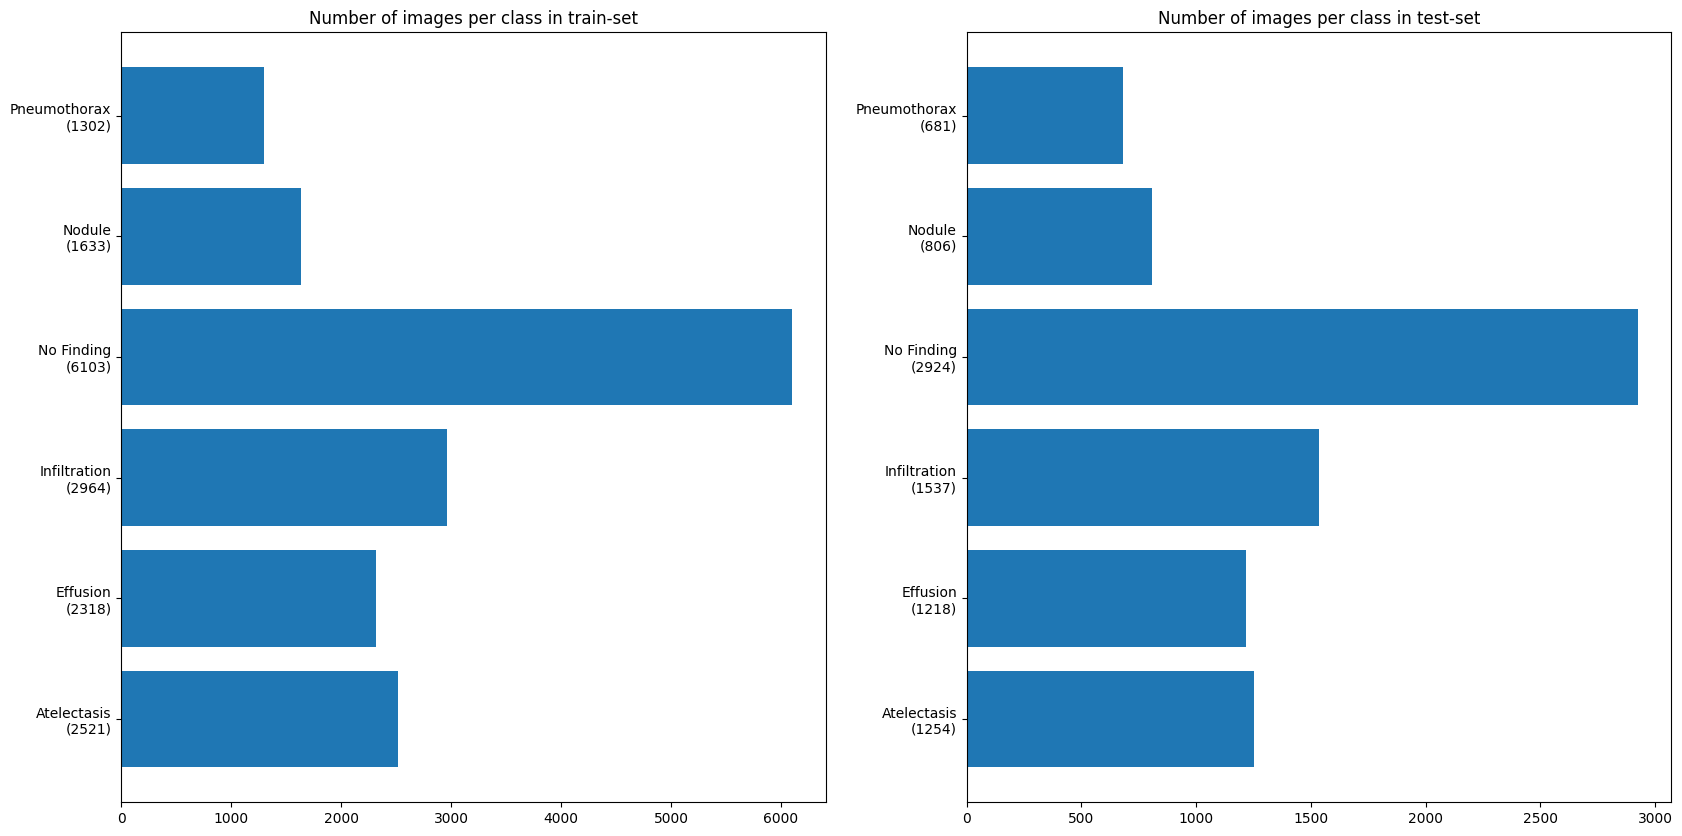

In [146]:
#@title
# Plotting the label distribution in train/test set:
fig, ax = plt.subplots(ncols=2, figsize=[20,10])

unique, counts = np.unique(train_y, return_counts=True) 
ax[0].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[0].set_title('Number of images per class in train-set')

unique, counts = np.unique(test_y, return_counts=True) 
ax[1].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[1].set_title('Number of images per class in test-set');

In [147]:
# Plot data distribution after data augmentation

#Plotting some samples:

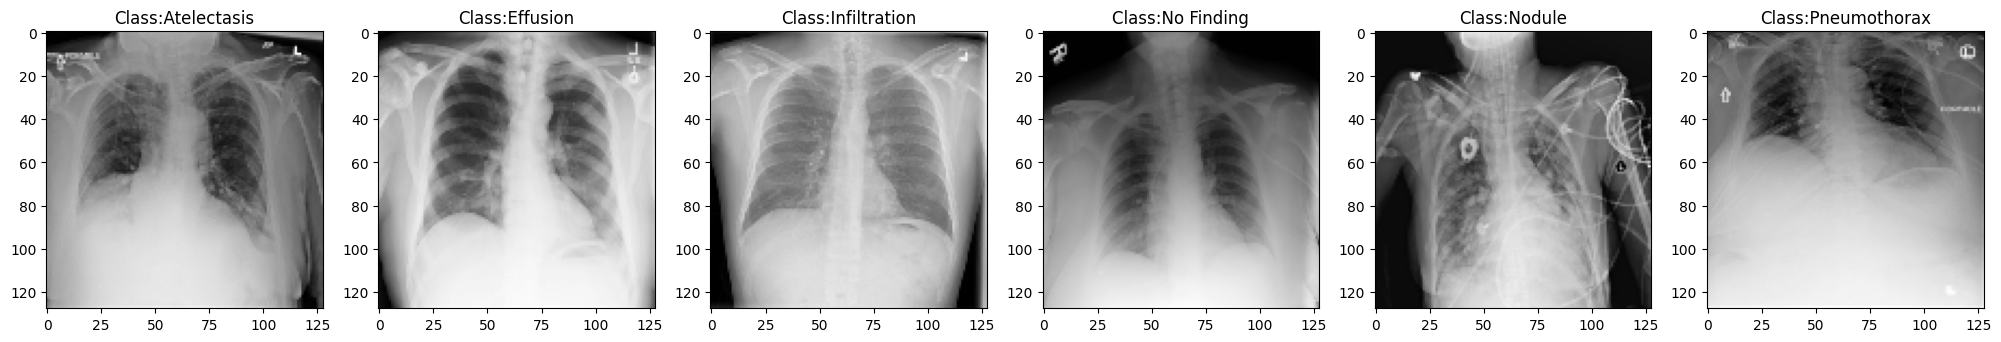

In [148]:
#@title
# Plotting some images
unique_labels = set(class_labels.keys())
fig, ax = plt.subplots(ncols=len(unique_labels), figsize=[25,5])

for k, label in enumerate(unique_labels):
  ind = list(train_y).index(label)
  ax[k].imshow(train_x[ind].reshape(128,128), cmap='gray')
  ax[k].set_title(f'Class:{class_labels[train_y[ind]]}')

# Building torch datasets:

In [150]:
# Lets now train and test our model for multiple epochs:
batch_size = 100

train_sampler = BatchSampler(batch_size=batch_size, dataset=train_dataset, balanced=True)
test_sampler = BatchSampler(batch_size=100, dataset=test_dataset, balanced=True)

# Defining our model as a neural network:
**TODO** define your own model here, follow the structure as presented in the Pytorch tutorial (or see below as an example).

### Original Model Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self, n_classes: int) -> None:
        super(Net, self).__init__()

        self.n_classes = n_classes  # <--- If you want a 'n_classes' attribute
        self.cnn_layers = nn.Sequential(
            # 2D convolution
            nn.Conv2d(1, 64, kernel_size=4, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4),
            nn.Dropout(p=0.5, inplace=True),

            nn.Conv2d(64, 32, kernel_size=4, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(p=0.25, inplace=True),

            nn.Conv2d(32, 16, kernel_size=4, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.125, inplace=True),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(144, 256),
            nn.Linear(256, n_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# Make sure your model instance is assigned to a variable 'model':
model = Net(n_classes = 6)

optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Defining our loss and optimizer functions:
**TODO** Please define your own optimizer and loss function.

In [165]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

#Moving model to CUDA, verifying model structure and printing a summary:

In [166]:
# IMPORTANT! Set this to True to see actual errors regarding 
# the structure of your model (CUDA hides them)!
# Also make sure you set this to False again for actual model training
# as training your model with GPU-acceleration (CUDA) is much faster.
DEBUG = False

In [167]:
#@title
# Moving our model to the right device (CUDA will speed training up significantly!)
if torch.cuda.is_available() and not DEBUG:
  device = 'cuda'
  model.to(device)
  # Creating a summary of our model and its layers:
  summary(model, (1, 128, 128), device=device)
  print('cuda')
else:
  device='cpu'
  # Creating a summary of our model and its layers:
  summary(model, (1, 128, 128), device=device)
  print('cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           1,088
       BatchNorm2d-2         [-1, 64, 125, 125]             128
              ReLU-3         [-1, 64, 125, 125]               0
         MaxPool2d-4           [-1, 64, 31, 31]               0
           Dropout-5           [-1, 64, 31, 31]               0
            Conv2d-6           [-1, 32, 28, 28]          32,800
       BatchNorm2d-7           [-1, 32, 28, 28]              64
           Sigmoid-8           [-1, 32, 28, 28]               0
         MaxPool2d-9             [-1, 32, 9, 9]               0
          Dropout-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 16, 6, 6]           8,208
      BatchNorm2d-12             [-1, 16, 6, 6]              32
          Sigmoid-13             [-1, 16, 6, 6]               0
        MaxPool2d-14             [-1, 1

#Defining our training/testing methods:

#Training our model:

#Evaluation our model:
**TODO** write your own methods to evaluate the model. For example, calculate the accuracy of the model on the test-set:

This accuracy isn't great. Your task is to find a better model that performs better at the classification task. Other methods of evaluation might tell you more why a particular model is not performing well (accuracy is a quite limited aggregated performance metric). 

#Saving our model:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
torch.save(model.state_dict(), '/content/gdrive/My Drive/weights_model.txt')